### Adverse Actionable Machine Learning

This notebook demonstrates how data can be processed for training with `xgboost` to enforce certain relationships between the independent variable and the target. 

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Dummy Data

For this notebook we will be using a contrived variable that has a carefully engineered relationship with the target variable. The dummy data also consists of values we might encounter in the real world such as missing data and exception values.

In [2]:
# create a dummy dataset with the desired properties
N = 10_000
vals = [np.nan, -99, 999, *list(range(0, 20))]
prob = [0.20, 0.10, 0.30, *np.repeat(0.4/20, 20)]
x = np.random.choice(vals, N, p=prob)

In [3]:
pd.Series(x).fillna(-999).value_counts().sort_index()

-999.0    1998
-99.0      985
 0.0       190
 1.0       192
 2.0       185
 3.0       214
 4.0       209
 5.0       184
 6.0       205
 7.0       189
 8.0       219
 9.0       184
 10.0      202
 11.0      193
 12.0      178
 13.0      193
 14.0      183
 15.0      202
 16.0      196
 17.0      200
 18.0      203
 19.0      215
 999.0    3081
dtype: int64

### Create Binary Target

The dummy data will include a binary dependent variable with probability based on the value of the independent variable to create a relationship between the two.

In [4]:
# probabilities in same order as x-values
yprob = [0.01, 0.50, 0.05,
         *np.arange(0.10, 0.30, 0.04), # increase 0 to 4
         *np.arange(0.10, 0.30, 0.04), # increase 5 to 10
         *np.arange(0.30, 0.10, -0.02)] # decrease 11 to 19

# get the sorted indices for the next step
i = np.argsort(vals)

# find the indices of x in the sorted values of x
index = np.searchsorted(np.array(vals)[i], x, side='left')

# use the indices to pair with the desired probability and randomly draw [0,1]
y = np.random.binomial(1, np.array(yprob)[i[index]])

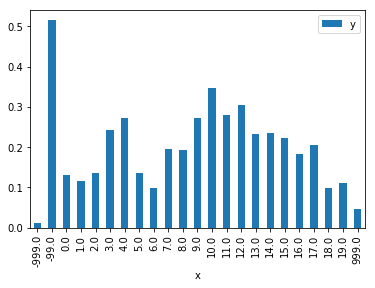

In [5]:
df = pd.DataFrame({"x": x, "y": y})
z = df.fillna(-999).groupby("x").mean()
plt = z.plot(kind="bar")

### Train Model

The first model fit will not use any constraints at all.

In [6]:
dtrain = xgb.DMatrix(x.reshape(-1, 1), label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta":1,
    "silent":1,
    "objective":"binary:logistic"
}

In [7]:
bst = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

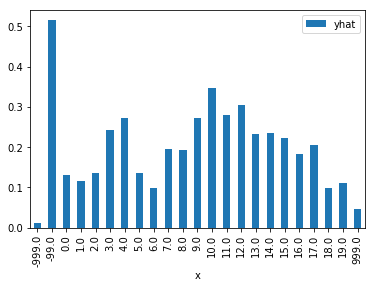

In [8]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

### Enforce Constraints

Regulations and repulational risk considerations demand that we treat certain levels of this variable in a special manner. Guidelines and experience recommend the following treatments:

| Value | Treatment |
|-------|-----------|
| Missing | Least points |
|-99 | Most Points |
|999 | Less than 0 to 20  |
|0 to 20 | Increasing Monotonicity |

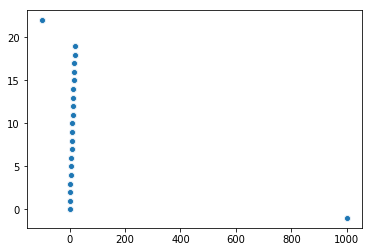

In [9]:
x_new = x.copy()

x_new[np.isnan(x)] = -2
x_new[x == 999] = -1
x_new[x == -99] = 22

sns.scatterplot(x, x_new)

In [10]:
dtrain = xgb.DMatrix(x_new.reshape(-1, 1), label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective":"binary:logistic",
    "monotone_constraints": "(1)"    
}

In [11]:
bst2 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst2.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

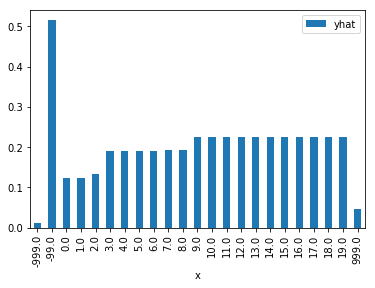

In [12]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

### More Complicated Constraints

Regulations and repulational risk considerations demand that we treat certain levels of this variable in a special manner. Guidelines and experience recommend the following treatments:

| Value | Treatment |
|-------|-----------|
| Missing | Least points |
|-99 | Most Points |
|999 | Less than 0 to 20  |
|0 to 10 | Increasing Monotonicity |
|11 to 20 | Decreasing Monotonicity |


In [13]:
x_inc1 = x.copy()

x_inc1[np.isnan(x)] = -3
x_inc1[x == 999] = -2
x_inc1[x == -99] = 12
x_inc1[x_inc1 > 10] = -1

x_inc2 = x_inc1.copy()
x_inc2[x_inc1 == -1] = 11

data = np.hstack([x_inc1.reshape(-1,1), x_inc2.reshape(-1,1)])
dtrain = xgb.DMatrix(data, label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective":"binary:logistic",
    "monotone_constraints": "(1, 1)"
}

In [14]:
bst3 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst3.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

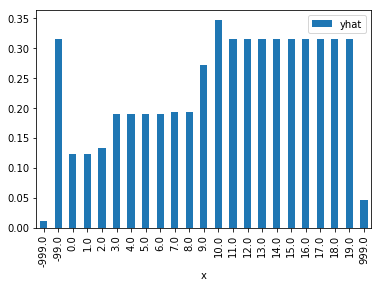

In [15]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

In [16]:
## repeat for decreasing mono
x_dec1 = x.copy()

x_dec1[np.isnan(x)] = 22
x_dec1[x == 999] = 21
x_dec1[x == -99] = -2
x_dec1[(x_dec1 >= 0) & (x_dec1 <= 10)] = -1

x_dec2 = x_dec1.copy()
x_dec2[x_dec2 == -1] = 20

In [17]:
data = np.hstack([
    x_inc1.reshape(-1,1), x_inc2.reshape(-1,1),
    x_dec1.reshape(-1,1), x_dec2.reshape(-1,1),
])

dtrain = xgb.DMatrix(data, label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective": "binary:logistic",
    "monotone_constraints": "(1, 1, -1, -1)"
}

bst4 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst4.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

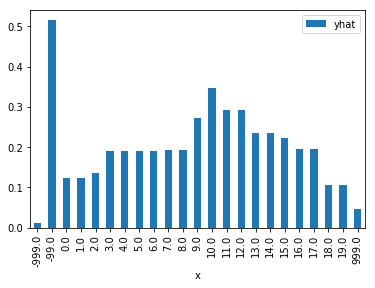

In [18]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

### Even More Complicated Constraints

Regulations and repulational risk considerations demand that we treat certain levels of this variable in a special manner. Guidelines and experience recommend the following treatments:

| Value | Treatment |
|-------|-----------|
| Missing | Least points |
|-99 | Most Points |
|999 | Less than 0 to 20  |
|0 to 5 | Increasing Monotonicity |
|6 to 10 | Increasing Monotonicity |
|11 to 20 | Decreasing Monotonicity |


Notes: Each interval must place *other* intervals prior and subsequent to it's range for monotonic constraints. 

Need to investigate whether ALL other intervals can be collapsed into one value to effect this behavior.

### Steps needed to output variable specification

1. All levels must have a priority order
2. Intervals output 2 columns
3. Each interval must be considered in turn
4. Other intervals must be slotted appropriately based on relationship to current interval

In [19]:
from constraints import *

tf = Constrainer([
    Missing(0),
    Value(-99, 3),
    Value(999, 1),
    Interval(0, 5, False, False, 1, 2),
    Interval(6, 10, False, False, 1, 2),
    Interval(11, 20, False, False, -1, 2)
])

In [20]:
x_new = tf.fit_transform(x.reshape(-1, 1))
x_new.shape

    0 | Missing:             => -3
    3 | Value: -99           => 7
    1 | Value: 999           => -2
    2 | [0, 5]               => None
    2 | [6, 10]              => -1
    2 | [11, 20]             => -1
    0 | Missing:             => -3
    3 | Value: -99           => 7
    1 | Value: 999           => -2
    2 | [0, 5]               => None
    2 | [6, 10]              => 6
    2 | [11, 20]             => 6
    0 | Missing:             => 3
    3 | Value: -99           => 12
    1 | Value: 999           => 4
    2 | [0, 5]               => 5
    2 | [6, 10]              => None
    2 | [11, 20]             => 5
    0 | Missing:             => 3
    3 | Value: -99           => 12
    1 | Value: 999           => 4
    2 | [0, 5]               => 11
    2 | [6, 10]              => None
    2 | [11, 20]             => 11
    0 | Missing:             => 23
    3 | Value: -99           => 9
    1 | Value: 999           => 22
    2 | [0, 5]               => 10
    2 | [6, 10]        

(10000, 6)

In [28]:
dtrain = xgb.DMatrix(x_new, label=y.reshape(-1, 1))

param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective": "binary:logistic",
    "monotone_constraints": "(1, 1, 1, 1, -1, -1)"
}

bst5 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst5.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

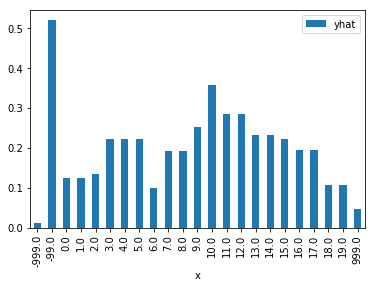

In [29]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

In [68]:
## mono between 0 and 5
x_inc1 = x.copy()

x_inc1[np.isnan(x)] = -3
x_inc1[x == 999] = -2
x_inc1[x_inc1 > 5] = -1
x_inc1[x == -99] = 7


x_inc2 = x_inc1.copy()
x_inc2[x_inc1 == -1] = 6

## mono between 6 and 10
x_inc3 = x.copy()

x_inc3[np.isnan(x)] = -3
x_inc3[~((x_inc3 > 5) & (x_inc3 <= 10))] = -1
x_inc3[x == 999] = -2
x_inc3[x == -99] = 12


x_inc4 = x.copy()
x_inc4[x_inc3 == -1] = 11

## mono between 11 and 20
x_dec1 = x.copy()

x_dec1[np.isnan(x)] = 22
x_dec1[x == 999] = 21
x_dec1[x == -99] = -2
x_dec1[(x_dec1 >= 0) & (x_dec1 <= 10)] = -1

x_dec2 = x_dec1.copy()
x_dec2[x_dec2 == -1] = 20

data = np.hstack([
    x_inc1.reshape(-1,1), x_inc2.reshape(-1,1),
    x_inc3.reshape(-1,1), x_inc4.reshape(-1,1),
    x_dec1.reshape(-1,1), x_dec2.reshape(-1,1)
])


dtrain = xgb.DMatrix(data, label=y.reshape(-1, 1))

param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective": "binary:logistic",
    "monotone_constraints": "(1, 1, 1, 1, -1, -1)"
}

bst5 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst5.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

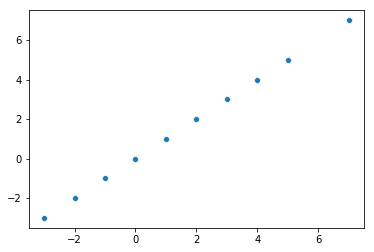

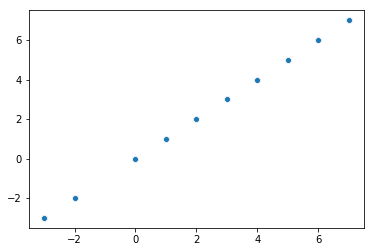

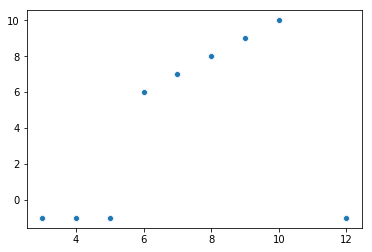

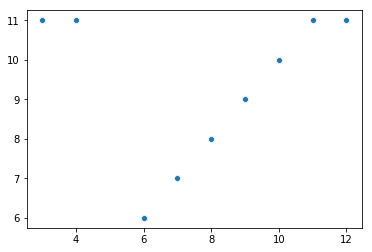

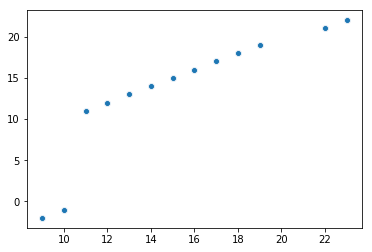

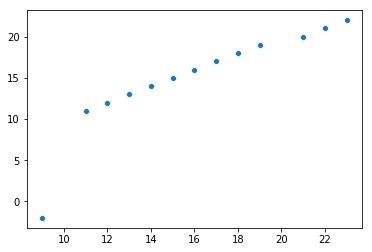

In [63]:
import matplotlib.pyplot as plt
x_new, data

for i in range(x_new.shape[1]):
    plt.figure(i)
    sns.scatterplot(x_new[:,i], data[:,i])    
    # plt.clf()

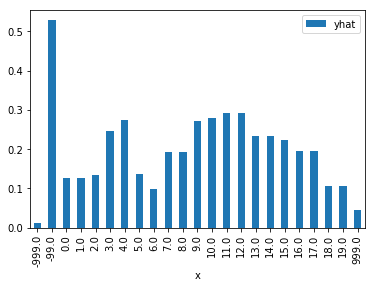

In [47]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

### Check Results

Here we can programatically test whether the requested conditions are satisfied by checking the mean predictions for each value of `x`.

In [71]:
from collections import namedtuple

res = preds.fillna(-999).groupby('x').mean()

conds = namedtuple("Conditions", " ".join([f"cond{i}" for i in range(1,7)]))

# verify all conditions are met:
conds(
    np.all(res.yhat.loc[range(0,20)] > res.yhat.loc[999]),
    np.all(res.yhat.loc[range(0,20)] < res.yhat.loc[-99]),
    np.all(res.yhat >= res.yhat.loc[-999]),
    np.all(
        res.yhat.loc[range(0,6)][1:].reset_index(drop=True) >=
        res.yhat.loc[range(0,6)][:-1].reset_index(drop=True)),
    np.all(
        res.yhat.loc[range(6,11)][1:].reset_index(drop=True) >=
        res.yhat.loc[range(6,11)][:-1].reset_index(drop=True)),
    np.all(
        res.yhat.loc[range(11,20)][1:].reset_index(drop=True) <=
        res.yhat.loc[range(11,20)][:-1].reset_index(drop=True))
)

Conditions(cond1=True, cond2=True, cond3=True, cond4=True, cond5=True, cond6=True)

### Using the Results for Adverse Action

In [26]:
# TODO: conda doesn't have latest version of xgboost which can dump json
import xgboost
xgboost.__version__

'0.80'

In [27]:
bst4.dump_model("./mono_model.json", dump_format='json')

TypeError: dump_model() got an unexpected keyword argument 'dump_format'